Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, experimental

In [2]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/UpGrad/assignment/cnn/CNN_assignment.zip

Archive:  /content/gdrive/MyDrive/UpGrad/assignment/cnn/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_002

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')
data_dir_train, data_dir_test 

(PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Test'))

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

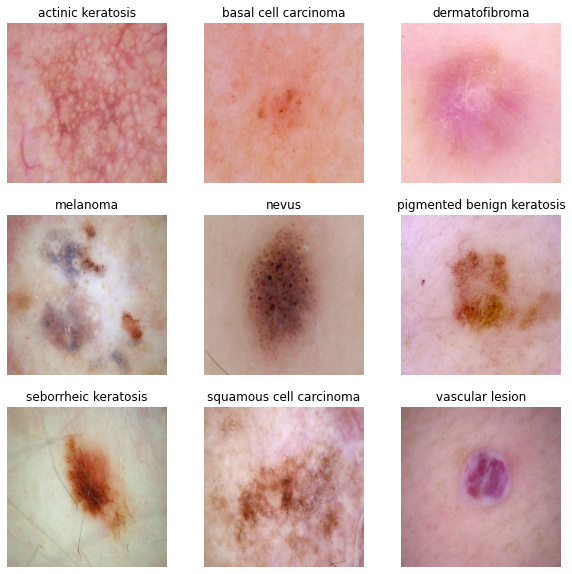

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for class_name in class_names:
  idx = class_names.index(class_name)
  train_ds_filt = train_ds.unbatch().filter(lambda x, y: y == idx).take(1)
  for image, label in train_ds_filt:
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
num_classes = 9

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
# optimizer='SGD', loss='categorical_crossentropy'
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
56/56 - 23s - loss: 1.9973 - accuracy: 0.2600 - val_loss: 1.7684 - val_accuracy: 0.2841 - 23s/epoch - 404ms/step
Epoch 2/20
56/56 - 3s - loss: 1.7029 - accuracy: 0.3890 - val_loss: 1.5675 - val_accuracy: 0.4787 - 3s/epoch - 45ms/step
Epoch 3/20
56/56 - 2s - loss: 1.5322 - accuracy: 0.4738 - val_loss: 1.3925 - val_accuracy: 0.5190 - 2s/epoch - 44ms/step
Epoch 4/20
56/56 - 2s - loss: 1.3398 - accuracy: 0.5324 - val_loss: 1.4068 - val_accuracy: 0.5235 - 2s/epoch - 44ms/step
Epoch 5/20
56/56 - 2s - loss: 1.3105 - accuracy: 0.5413 - val_loss: 1.4183 - val_accuracy: 0.5078 - 2s/epoch - 44ms/step
Epoch 6/20
56/56 - 2s - loss: 1.2304 - accuracy: 0.5698 - val_loss: 1.4572 - val_accuracy: 0.5101 - 2s/epoch - 44ms/step
Epoch 7/20
56/56 - 2s - loss: 1.1724 - accuracy: 0.5999 - val_loss: 1.3966 - val_accuracy: 0.5280 - 2s/epoch - 44ms/step
Epoch 8/20
56/56 - 2s - loss: 1.0203 - accuracy: 0.6345 - val_loss: 1.3460 - val_accuracy: 0.5481 - 2s/epoch - 44ms/step
Epoch 9/20
56/56 - 2s - loss:

### Visualizing training results

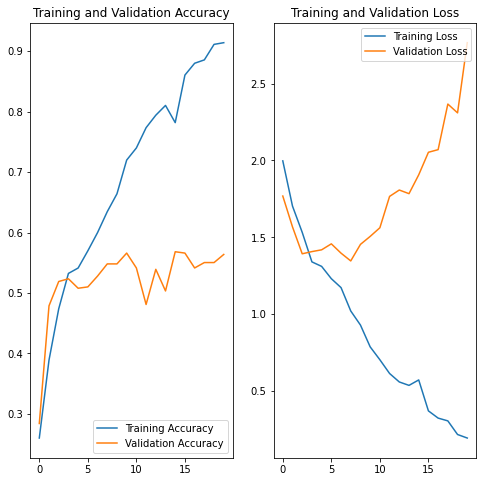

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 53~54% accuracy on the validation set.

The training accuracy is increasing almost linearly over epochs, whereas validation accuracy stalls around 52% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — **a sign of overfitting**.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. We'll use data augmentation and add dropout to the model.

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield similar images. This helps the model to train from more aspects of the data and generalize better.

We will implement data augmentation using the following Keras preprocessing layers: 
- tf.keras.layers.RandomFlip, 
- tf.keras.layers.RandomRotation, and 
- tf.keras.layers.RandomZoom. 

This will be included inside the model like other layers. We will add data augmentation to the model before training in the next step.


#### Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When we apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

We will create a new neural network with **tf.keras.layers.Dropout** before training it using the augmented images.

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
  ])

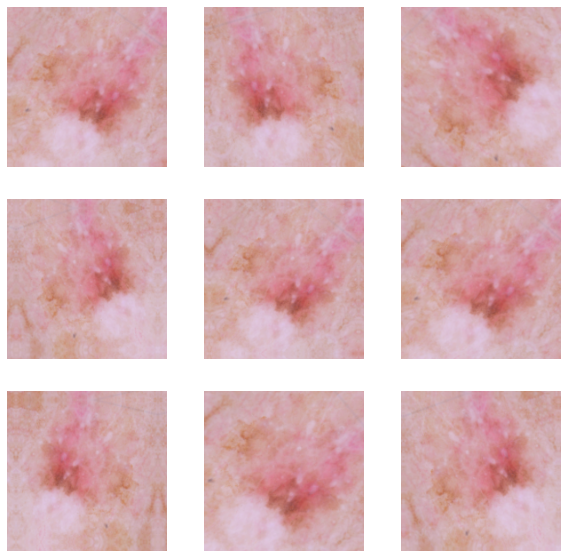

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compiling the model

In [21]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
# history = ## your training code

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
56/56 - 4s - loss: 2.1440 - accuracy: 0.2584 - val_loss: 1.7269 - val_accuracy: 0.3490 - 4s/epoch - 78ms/step
Epoch 2/20
56/56 - 3s - loss: 1.6738 - accuracy: 0.4107 - val_loss: 1.5769 - val_accuracy: 0.4385 - 3s/epoch - 60ms/step
Epoch 3/20
56/56 - 3s - loss: 1.5330 - accuracy: 0.4559 - val_loss: 1.4821 - val_accuracy: 0.4966 - 3s/epoch - 60ms/step
Epoch 4/20
56/56 - 3s - loss: 1.4425 - accuracy: 0.4933 - val_loss: 1.4826 - val_accuracy: 0.4765 - 3s/epoch - 60ms/step
Epoch 5/20
56/56 - 3s - loss: 1.3628 - accuracy: 0.5128 - val_loss: 1.3928 - val_accuracy: 0.5168 - 3s/epoch - 59ms/step
Epoch 6/20
56/56 - 3s - loss: 1.3416 - accuracy: 0.5268 - val_loss: 1.4702 - val_accuracy: 0.4765 - 3s/epoch - 60ms/step
Epoch 7/20
56/56 - 3s - loss: 1.3316 - accuracy: 0.5212 - val_loss: 1.3920 - val_accuracy: 0.5213 - 3s/epoch - 59ms/step
Epoch 8/20
56/56 - 3s - loss: 1.3040 - accuracy: 0.5324 - val_loss: 1.4122 - val_accuracy: 0.4899 - 3s/epoch - 60ms/step
Epoch 9/20
56/56 - 3s - loss: 1.

### Visualizing the results

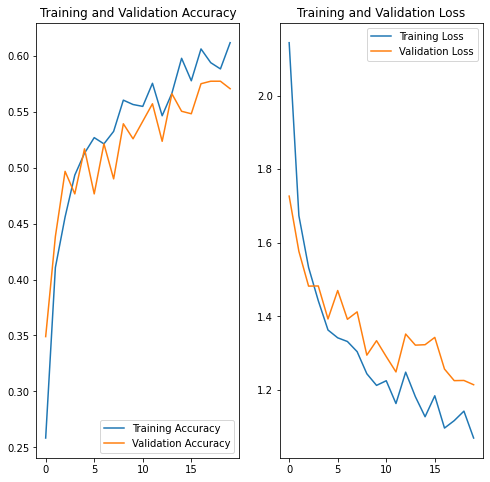

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

The training accuracy is around 60% and the validation accuracy is around 56~57%.

It seems, the data augmentation and dropout has helped the model training better, still it is not able to generalize the data and the accuracy during training (on vaidation data) is not very good.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Found 2239 files belonging to 9 classes.


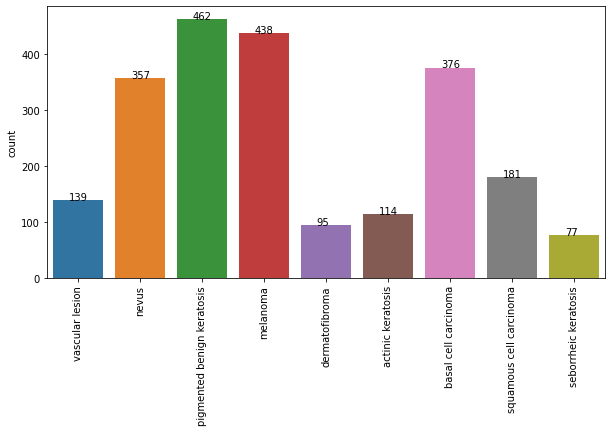

In [25]:
## Your code goes here.

train_ds_full = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

plt.figure(figsize=(10,5))
list_label = list(train_ds_full.unbatch().map(lambda x, y : y).as_numpy_iterator())
list_label_names = [class_names[x] for x in list_label]
import seaborn as sns
ax = sns.countplot(x=list_label_names)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

**seborrheic keratosis** class has the least nos. of samples (77 nos)

#### - Which classes dominate the data in terms proportionate number of samples?

**nevus, pigmented benign keratosis, melanoma and basal cell carcinoma** classes dominate the data in terms proportionate number of samples as their numbers are **almost 3 times** the same of the other classes

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F060A0DDB20>: 100%|██████████| 500/500 [00:21<00:00, 22.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F060A1C4F10>: 100%|██████████| 500/500 [00:21<00:00, 23.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F060A091C40>: 100%|██████████| 500/500 [00:17<00:00, 27.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F06603208E0>: 100%|██████████| 500/500 [01:24<00:00,  5.89 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F06D5AEC460>: 100%|██████████| 500/500 [01:14<00:00,  6.69 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F06D8364DC0>: 100%|██████████| 500/500 [00:16<00:00, 30.89 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F060A14D5B0>: 100%|██████████| 500/500 [00:38<00:00, 12.93 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F060A1982E0>: 100%|██████████| 500/500 [00:16<00:00, 30.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05F4360430>: 100%|██████████| 500/500 [00:15<00:00, 31.33 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob

In [30]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
# path_list_old
len(path_list_old)

2239

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list_new
len(path_list_new)

4500

In [32]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
# lesion_list_old
len(lesion_list_old)

2239

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new
len(lesion_list_new)

4500

In [34]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [38]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here

model = Sequential([
#   data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

#### **Todo:**  Train your model

In [46]:
epochs = 30
## Your code goes here, use 50 epochs.
# history = # your model fit code

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 29s - loss: 1.9337 - accuracy: 0.2667 - val_loss: 1.5219 - val_accuracy: 0.3890 - 29s/epoch - 172ms/step
Epoch 2/30
169/169 - 8s - loss: 1.4477 - accuracy: 0.4451 - val_loss: 1.2759 - val_accuracy: 0.5234 - 8s/epoch - 45ms/step
Epoch 3/30
169/169 - 8s - loss: 1.2620 - accuracy: 0.5195 - val_loss: 1.1387 - val_accuracy: 0.5872 - 8s/epoch - 45ms/step
Epoch 4/30
169/169 - 8s - loss: 1.0811 - accuracy: 0.5942 - val_loss: 0.9617 - val_accuracy: 0.6548 - 8s/epoch - 45ms/step
Epoch 5/30
169/169 - 8s - loss: 0.8803 - accuracy: 0.6779 - val_loss: 0.9443 - val_accuracy: 0.6637 - 8s/epoch - 45ms/step
Epoch 6/30
169/169 - 8s - loss: 0.7383 - accuracy: 0.7315 - val_loss: 0.8895 - val_accuracy: 0.6748 - 8s/epoch - 45ms/step
Epoch 7/30
169/169 - 8s - loss: 0.5790 - accuracy: 0.7847 - val_loss: 0.7972 - val_accuracy: 0.7372 - 8s/epoch - 45ms/step
Epoch 8/30
169/169 - 8s - loss: 0.4280 - accuracy: 0.8474 - val_loss: 0.8828 - val_accuracy: 0.7313 - 8s/epoch - 45ms/step
Epoch 9/30
16

#### **Todo:**  Visualize the model results

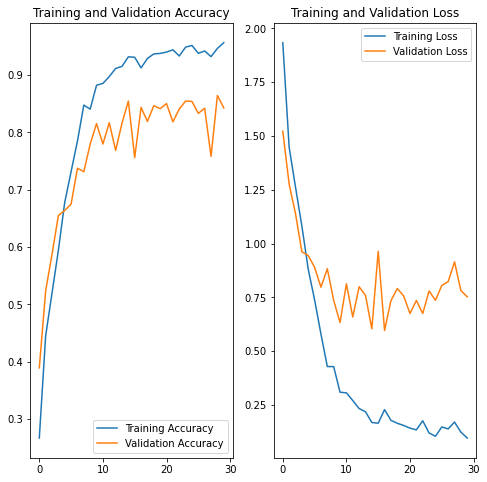

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings of 1st Model

The First Model was trained without the data augmentation layer and improvement in accuracy was observed.
The training accuracy was 95% and validation accuracy was around 82~83%.
Looking at the gap, it was inferred that the modell still suffers from overfitting 

### Second Model

A second model was created with following modifications:
- addition of a convolution layer 
- added dropout (0.5) on the classification layer (dense layer)
- reduction of neurons in one of the Dense Layers

In [48]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [51]:
epochs = 30
## Your code goes here, use 50 epochs.
# history = # your model fit code

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 5s - loss: 1.9888 - accuracy: 0.2348 - val_loss: 1.5812 - val_accuracy: 0.4031 - 5s/epoch - 32ms/step
Epoch 2/30
169/169 - 5s - loss: 1.5970 - accuracy: 0.3804 - val_loss: 1.4678 - val_accuracy: 0.4454 - 5s/epoch - 27ms/step
Epoch 3/30
169/169 - 4s - loss: 1.4969 - accuracy: 0.4191 - val_loss: 1.3247 - val_accuracy: 0.4766 - 4s/epoch - 24ms/step
Epoch 4/30
169/169 - 4s - loss: 1.3695 - accuracy: 0.4627 - val_loss: 1.2457 - val_accuracy: 0.5167 - 4s/epoch - 24ms/step
Epoch 5/30
169/169 - 4s - loss: 1.2938 - accuracy: 0.4930 - val_loss: 1.2032 - val_accuracy: 0.5219 - 4s/epoch - 24ms/step
Epoch 6/30
169/169 - 4s - loss: 1.1997 - accuracy: 0.5404 - val_loss: 1.0967 - val_accuracy: 0.5798 - 4s/epoch - 25ms/step
Epoch 7/30
169/169 - 4s - loss: 1.0777 - accuracy: 0.5844 - val_loss: 0.9707 - val_accuracy: 0.6154 - 4s/epoch - 24ms/step
Epoch 8/30
169/169 - 4s - loss: 0.9536 - accuracy: 0.6343 - val_loss: 0.8697 - val_accuracy: 0.6719 - 4s/epoch - 24ms/step
Epoch 9/30
169/1

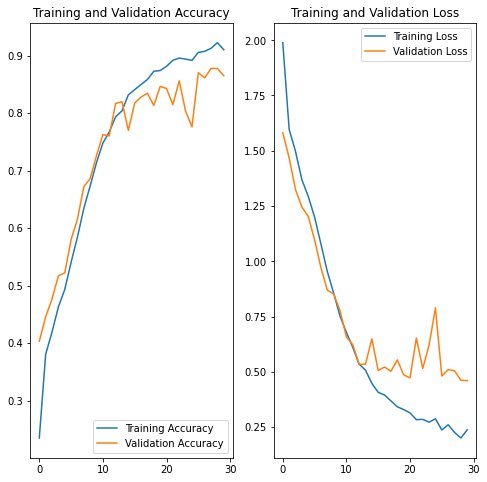

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings of the Second Model

The **overfitting reduced**, but still present and the validation accuracy improved to around **85~86%**

### Third Model

A Third model was created with following modifications:
- doubling the filters in each convolution layer 
- dropout remained same

In [53]:
model3 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [54]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 128)      

In [56]:
epochs = 30
## Your code goes here, use 50 epochs.
# history = # your model fit code

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 9s - loss: 2.1457 - accuracy: 0.1745 - val_loss: 2.0835 - val_accuracy: 0.2094 - 9s/epoch - 51ms/step
Epoch 2/30
169/169 - 8s - loss: 1.8693 - accuracy: 0.2830 - val_loss: 1.5478 - val_accuracy: 0.4165 - 8s/epoch - 45ms/step
Epoch 3/30
169/169 - 8s - loss: 1.5968 - accuracy: 0.3809 - val_loss: 1.4234 - val_accuracy: 0.4269 - 8s/epoch - 45ms/step
Epoch 4/30
169/169 - 8s - loss: 1.4325 - accuracy: 0.4390 - val_loss: 1.3134 - val_accuracy: 0.4907 - 8s/epoch - 45ms/step
Epoch 5/30
169/169 - 8s - loss: 1.3009 - accuracy: 0.4917 - val_loss: 1.1998 - val_accuracy: 0.5523 - 8s/epoch - 45ms/step
Epoch 6/30
169/169 - 8s - loss: 1.2196 - accuracy: 0.5282 - val_loss: 1.0844 - val_accuracy: 0.5984 - 8s/epoch - 45ms/step
Epoch 7/30
169/169 - 8s - loss: 1.1055 - accuracy: 0.5827 - val_loss: 1.0014 - val_accuracy: 0.6377 - 8s/epoch - 45ms/step
Epoch 8/30
169/169 - 8s - loss: 0.9505 - accuracy: 0.6291 - val_loss: 0.8049 - val_accuracy: 0.7068 - 8s/epoch - 45ms/step
Epoch 9/30
169/1

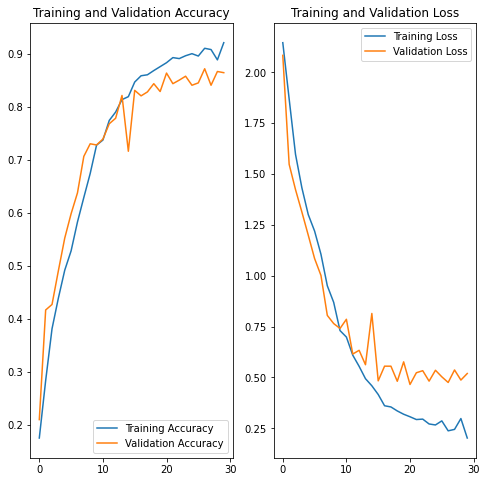

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings of the Third Model

The **overfitting highly reduced**, and the validation accuracy remained at around **85~86%**

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalnce lragely improved the overall accuracy during training.
- the training accuracy improved from 60% to 89~90%
- the validation accuracy improved from 52 ~ 54% to around 85 ~ 86%

The overfitting was reduced by use of Dropouts after the convolution layer and the dense classification layer.
- the gap between the training and validation reduced to ~4%

Validation Accuracy of the model was hugely improved from 52 ~ 54% to around 85~86% by using data augmentation and class rebalancing.

Data augmentation added variations of the original image which helped the model generalize the learning.

Class imbalance can result in bad model performance, which can be addressed by adding a reasonable nos. of augmented images to each class, so that the effect of class imbalance is reduced.

### Checking the Result on the Test Data 


In [58]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [59]:
loss, acc = model3.evaluate(test_ds)
print("Accuracy", acc)

4/4 [==============================] - 4s 107ms/step - loss: 5.1318 - accuracy: 0.3814
Accuracy 0.3813559412956238


In [60]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

4/4 [==============================] - 3s 68ms/step - loss: 5.1990 - accuracy: 0.3898
Accuracy 0.38983049988746643


### Checking Prediction on Test Data, Image by Image

In [68]:
import glob

y = []
y_pred = []
for file_path in glob.glob('Skin cancer ISIC The International Skin Imaging Collaboration/Test/*/*.jpg', recursive=True):
    actual_class = os.path.basename(os.path.dirname(file_path))
#     print()
    print(file_path) 
    img = tf.keras.utils.load_img(
        file_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This {} image most likely belongs to {} with a {:.2f} percent confidence."
        .format(actual_class, class_names[np.argmax(score)], 100 * np.max(score))
    )
    
    y.append(actual_class)
    y_pred.append(class_names[np.argmax(score)])
    

Skin cancer ISIC The International Skin Imaging Collaboration/Test/squamous cell carcinoma/ISIC_0024517.jpg
1/1 [==============================] - 0s 225ms/step
This squamous cell carcinoma image most likely belongs to basal cell carcinoma with a 74.21 percent confidence.
Skin cancer ISIC The International Skin Imaging Collaboration/Test/squamous cell carcinoma/ISIC_0011593.jpg
1/1 [==============================] - 0s 21ms/step
This squamous cell carcinoma image most likely belongs to nevus with a 100.00 percent confidence.
Skin cancer ISIC The International Skin Imaging Collaboration/Test/squamous cell carcinoma/ISIC_0024463.jpg
1/1 [==============================] - 0s 16ms/step
This squamous cell carcinoma image most likely belongs to pigmented benign keratosis with a 94.93 percent confidence.
Skin cancer ISIC The International Skin Imaging Collaboration/Test/squamous cell carcinoma/ISIC_0024418.jpg
1/1 [==============================] - 0s 16ms/step
This squamous cell carcinoma im

In [69]:
df_result = pd.DataFrame({'y': y, 'y_pred': y_pred})
df_result

,y,y_pred
0,squamous cell carcinoma,basal cell carcinoma
1,squamous cell carcinoma,nevus
2,squamous cell carcinoma,pigmented benign keratosis
3,squamous cell carcinoma,pigmented benign keratosis
4,squamous cell carcinoma,melanoma
...,...,...
113,pigmented benign keratosis,pigmented benign keratosis
114,pigmented benign keratosis,pigmented benign keratosis
115,pigmented benign keratosis,squamous cell carcinoma
116,pigmented benign keratosis,pigmented benign keratosis


In [70]:
df_result.shape

(118, 2)

### Checking the Prediction for Melanoma on Test Data

In [71]:
df_result[df_result.y == 'melanoma']

,y,y_pred
48,melanoma,pigmented benign keratosis
49,melanoma,melanoma
50,melanoma,melanoma
51,melanoma,nevus
52,melanoma,nevus
53,melanoma,melanoma
54,melanoma,nevus
55,melanoma,pigmented benign keratosis
56,melanoma,nevus
57,melanoma,melanoma
